In [1]:
import numpy as np
import pandas as pd
import sklearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


## 0. Loading DataSet

In [2]:
data_set = np.genfromtxt('Data\magic04.data', delimiter=',', dtype=str) # Data is in the form of array of tuples
labels = data_set[:, len(data_set[0]) - 1:len(data_set[0])]

# 1. Data Balancing

In [3]:
under_sampler = RandomUnderSampler()
sampled_data, sampled_labels = under_sampler.fit_resample(data_set, labels)

In [4]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(sampled_labels, return_counts=True)
print(dict(zip(unique, counts)))

{'g': 12332, 'h': 6688}
{'g': 6688, 'h': 6688}


# 2. Data Split


In [5]:
training_data_set, testing_data_set = train_test_split(data_set, test_size=0.3)

In [6]:
training_data = np.array(training_data_set[:, 0:len(training_data_set[0]) - 1]).astype(np.float64)
training_labels = training_data_set[:, len(training_data_set[0]) - 1:len(training_data_set[0])]
training_labels = np.reshape(training_labels, len(training_labels))

In [7]:
testing_data = np.array(testing_data_set[:, 0:len(testing_data_set[0]) - 1]).astype(np.float64)
testing_labels = testing_data_set[:, len(testing_data_set[0]) - 1:len(testing_data_set[0])]
testing_labels = np.reshape(testing_labels, len(testing_labels))

# 3. Classification

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

### (a) Decision Tree

In [9]:
def decision_tree(tr_data, tr_labels, tst_data):
    decision_tree = tree.DecisionTreeClassifier()
    decision_tree_pred = decision_tree.fit(tr_data, tr_labels).predict(tst_data)
    return decision_tree_pred

### (b) AdaBoost

In [10]:
def ada_boost(tr_data, tr_labels, tst_data, n_estimators):
    ada_boost = AdaBoostClassifier(n_estimators=n_estimators)
    ada_boost_pred = ada_boost.fit(tr_data, tr_labels).predict(tst_data)
    return ada_boost_pred
    

### (c) K-Nearest Neighbors (K-NN)

In [11]:
def knn(tr_data, tr_labels, tst_data, k_neighb = 3):
    neigh = KNeighborsClassifier(n_neighbors=k_neighb)
    knn_pred = neigh.fit(tr_data, tr_labels).predict(tst_data)
    return knn_pred

### (d) Random Forests


In [12]:
def random_forests(tr_data, tr_labels, tst_data, n_estimators):
    random_forests = RandomForestClassifier(n_estimators=n_estimators)
    random_forests_pred = random_forests.fit(tr_data, tr_labels).predict(tst_data)
    return random_forests_pred
    

### (e) Na¨ıve Bayes


In [13]:
def naive_bayes(tr_data, tr_labels, tst_data):
    gnb = GaussianNB()
    naive_bayes_pred = gnb.fit(tr_data, tr_labels).predict(tst_data)
    return naive_bayes_pred

# 4. Model Parameter Tuning


In [14]:
decision_tree_pred = decision_tree(training_data, training_labels, testing_data)
print("Decision tree accuracy: ", accuracy_score(testing_labels, decision_tree_pred) * 100, "%")
precision_score(testing_labels, decision_tree_pred, average='weighted')
recall_score(testing_labels, decision_tree_pred, average='weighted')
f1_score(testing_labels, decision_tree_pred, average='weighted')

Decision tree accuracy:  81.30038555906064 %


0.8131722313229185

In [15]:
naive_bayes_pred = naive_bayes(training_data, training_labels, testing_data)
print("Na¨ıve bayes accuracy: ", accuracy_score(testing_labels, naive_bayes_pred) * 100, "%")
precision_score(testing_labels, naive_bayes_pred, average='weighted')
recall_score(testing_labels, naive_bayes_pred, average='weighted')
f1_score(testing_labels, naive_bayes_pred, average='weighted')

Na¨ıve bayes accuracy:  72.94076410795654 %


0.705033498538294

In [16]:
k_neighb = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
for k in k_neighb:
    knn_pred = knn(training_data, training_labels, testing_data, k)
    print(str(k) + "-NN accuracy: ", accuracy_score(testing_labels, knn_pred) * 100, "%")
    precision_score(testing_labels, knn_pred, average='weighted')
    recall_score(testing_labels, knn_pred, average='weighted')
    f1_score(testing_labels, knn_pred, average='weighted')

1-NN accuracy:  78.30354013319312 %
2-NN accuracy:  79.4602173151069 %
3-NN accuracy:  80.28391167192429 %
4-NN accuracy:  80.82719943918683 %
5-NN accuracy:  81.4055380301437 %
6-NN accuracy:  81.12513144058885 %
7-NN accuracy:  81.4931650893796 %
8-NN accuracy:  81.4055380301437 %
9-NN accuracy:  81.61584297230985 %
10-NN accuracy:  81.37048720644935 %
11-NN accuracy:  81.38801261829653 %
12-NN accuracy:  81.37048720644935 %
13-NN accuracy:  81.47563967753241 %
14-NN accuracy:  81.23028391167192 %
15-NN accuracy:  81.47563967753241 %
16-NN accuracy:  81.30038555906064 %
17-NN accuracy:  81.66841920785139 %
18-NN accuracy:  81.38801261829653 %
19-NN accuracy:  81.52821591307395 %
20-NN accuracy:  81.26533473536628 %


In [17]:
n_estimators = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
for n in n_estimators:
    ada_boost_pred = ada_boost(training_data, training_labels, testing_data, n)
    print(str(n) + "_estimators AdaBoost accuracy: ", accuracy_score(testing_labels, ada_boost_pred) * 100, "%")
    precision_score(testing_labels, ada_boost_pred, average='weighted')
    recall_score(testing_labels, ada_boost_pred, average='weighted')
    f1_score(testing_labels, ada_boost_pred, average='weighted')

90_estimators AdaBoost accuracy:  83.85909568874868 %
91_estimators AdaBoost accuracy:  84.10445145460919 %
92_estimators AdaBoost accuracy:  84.086926042762 %
93_estimators AdaBoost accuracy:  84.086926042762 %
94_estimators AdaBoost accuracy:  84.05187521906765 %
95_estimators AdaBoost accuracy:  84.15702769015073 %
96_estimators AdaBoost accuracy:  84.13950227830354 %
97_estimators AdaBoost accuracy:  84.12197686645636 %
98_estimators AdaBoost accuracy:  84.10445145460919 %
99_estimators AdaBoost accuracy:  84.29723098492815 %
100_estimators AdaBoost accuracy:  84.29723098492815 %


In [18]:
n_estimators = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
for n in n_estimators:
    random_forests_pred = random_forests(training_data, training_labels, testing_data, n)
    print(str(n) + "_estimators random forests accuracy: ", accuracy_score(testing_labels, random_forests_pred) * 100, "%")
    precision_score(testing_labels, random_forests_pred, average='weighted')
    recall_score(testing_labels, random_forests_pred, average='weighted')
    f1_score(testing_labels, random_forests_pred, average='weighted')

90_estimators random forests accuracy:  88.17034700315457 %
91_estimators random forests accuracy:  87.85488958990535 %
92_estimators random forests accuracy:  88.03014370837715 %
93_estimators random forests accuracy:  88.1528215913074 %
94_estimators random forests accuracy:  87.99509288468279 %
95_estimators random forests accuracy:  87.97756747283562 %
96_estimators random forests accuracy:  88.11777076761304 %
97_estimators random forests accuracy:  87.7497371188223 %
98_estimators random forests accuracy:  88.20539782684892 %
99_estimators random forests accuracy:  88.08271994391869 %
100_estimators random forests accuracy:  88.11777076761304 %


# 5. Report Requirements

# 6. Bonus

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing

In [20]:
EPOCHS = 2000

In [21]:
le = preprocessing.LabelEncoder()
training_encoded_labels = le.fit_transform(training_labels)
testing_encoded_labels = le.fit_transform(testing_labels)

In [22]:
print(f'Training Data Shape {training_data.shape}')
print(f'Training Label Shape {training_encoded_labels.shape}')

Training Data Shape (13314, 10)
Training Label Shape (13314,)


In [23]:
print(f'Training Data  {training_data[0]}')
print(f'Training Label {training_encoded_labels[0]}')

Training Data  [ 34.3113  13.4401   2.5871   0.4347   0.2212   5.0547 -21.7933   6.1834
  23.351  183.392 ]
Training Label 0


In [24]:
X_train_val = torch.from_numpy(training_data).float()
X_test = torch.from_numpy(testing_data).float()
y_train_val = torch.from_numpy(training_encoded_labels).float()
y_test = torch.from_numpy(testing_encoded_labels).float()

In [25]:
print(X_train_val.shape)
print(X_test.shape)

torch.Size([13314, 10])
torch.Size([5706, 10])


In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42) 

In [27]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([11982, 10])
torch.Size([1332, 10])
torch.Size([5706, 10])


In [28]:
class ClassificationModel(nn.Module):
    def __init__(self, input_layer, hidden_layer_1, hidden_layer_2, output_layer):
        super(ClassificationModel, self).__init__()
        self.l1 = nn.Linear(input_layer, hidden_layer_1)
        self.l2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.out = nn.Linear(hidden_layer_2, output_layer)
 
    def forward(self, data):
        x = self.l1(data)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.out(x)
        return torch.sigmoid(x)
     


In [29]:

def train_val_model(model, epochs, optimizer, loss_fn, X_train, X_val, y_train, y_val):
    acc_data_val = []
    acc_data_train = []
    loss_data_val = []
    loss_data_train = []

    for epoch in range(EPOCHS+1):
        optimizer.zero_grad()
        model.train()
        y_pred_train = model(X_train)
        loss_train = loss_fn(y_pred_train, y_train)
        loss_train.backward()
        optimizer.step()

        model.eval()
        y_pred_val = model(X_val)
        loss_val = loss_fn(y_pred_val, y_val)
        condition = y_pred_val >= 0.5
        y_pred_val = torch.where(condition, 1, 0)
        val_acc = torch.sum(y_pred_val == y_val) / len(y_val)

        condition = y_pred_train >= 0.5
        y_pred_train = torch.where(condition, 1, 0)
        train_acc = torch.sum(y_pred_train == y_train) / len(y_train)
        if epoch % 250 == 0:
            print(f'{epoch} : Training loss {loss_train} && Training Acc is {train_acc} || Test loss {loss_val} && Test Acc is {val_acc}')
        acc_data_val.append(val_acc)
        acc_data_train.append(train_acc)
        loss_data_val.append(loss_val.detach().numpy())
        loss_data_train.append(loss_train.detach().numpy())

    return acc_data_train, acc_data_val, loss_data_train, loss_data_val
            

In [30]:
model_1 = ClassificationModel(10, 16, 32, 1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-4)
acc_data_train_1, acc_data_val_1, loss_data_train_1, loss_data_val_1 = train_val_model(model_1, 2000, optimizer, loss_fn, X_train, X_val, y_train.reshape(-1, 1), y_val.reshape(-1, 1))

0 : Training loss 0.943087100982666 && Training Acc is 0.4475880563259125 || Test loss 0.9364085793495178 && Test Acc is 0.4587087035179138
250 : Training loss 0.5775763988494873 && Training Acc is 0.7224169373512268 || Test loss 0.5713141560554504 && Test Acc is 0.7102102041244507
500 : Training loss 0.5105680227279663 && Training Acc is 0.7493740320205688 || Test loss 0.5188628435134888 && Test Acc is 0.7424924969673157
750 : Training loss 0.48374661803245544 && Training Acc is 0.7674845457077026 || Test loss 0.49396172165870667 && Test Acc is 0.7582582831382751
1000 : Training loss 0.46326175332069397 && Training Acc is 0.7785845398902893 || Test loss 0.46905601024627686 && Test Acc is 0.7770270109176636
1250 : Training loss 0.44983983039855957 && Training Acc is 0.7884326577186584 || Test loss 0.4527779817581177 && Test Acc is 0.7867867946624756
1500 : Training loss 0.43880337476730347 && Training Acc is 0.7936070561408997 || Test loss 0.44056546688079834 && Test Acc is 0.795795798

In [31]:
model_2 = ClassificationModel(10, 64, 128, 1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-4)
acc_data_train_2, acc_data_val_2, loss_data_train_2, loss_data_val_2 = train_val_model(model_2, 2000, optimizer, loss_fn, X_train, X_val, y_train.reshape(-1, 1), y_val.reshape(-1, 1))

0 : Training loss 1.1365365982055664 && Training Acc is 0.5145217776298523 || Test loss 1.0671018362045288 && Test Acc is 0.5412912964820862
250 : Training loss 0.47281619906425476 && Training Acc is 0.767234206199646 || Test loss 0.481145441532135 && Test Acc is 0.7762762904167175
500 : Training loss 0.43531307578086853 && Training Acc is 0.7982807755470276 || Test loss 0.4468740224838257 && Test Acc is 0.804804801940918
750 : Training loss 0.410808265209198 && Training Acc is 0.8115506768226624 || Test loss 0.4275963008403778 && Test Acc is 0.8070570826530457
1000 : Training loss 0.39068567752838135 && Training Acc is 0.8258220553398132 || Test loss 0.41195541620254517 && Test Acc is 0.8130630850791931
1250 : Training loss 0.37507790327072144 && Training Acc is 0.8372558951377869 || Test loss 0.4006219804286957 && Test Acc is 0.8243243098258972
1500 : Training loss 0.36392536759376526 && Training Acc is 0.8428475856781006 || Test loss 0.3940747380256653 && Test Acc is 0.8348348140716

In [32]:
model_3 = ClassificationModel(10, 128, 512, 1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=1e-4)
acc_data_train_3, acc_data_val_3, loss_data_train_3, loss_data_val_3 = train_val_model(model_3, 2000, optimizer, loss_fn, X_train, X_val, y_train.reshape(-1, 1), y_val.reshape(-1, 1))

0 : Training loss 1.4020253419876099 && Training Acc is 0.3892505466938019 || Test loss 0.9306279420852661 && Test Acc is 0.4932432472705841
250 : Training loss 0.43222343921661377 && Training Acc is 0.7996160984039307 || Test loss 0.44442638754844666 && Test Acc is 0.7935435175895691
500 : Training loss 0.39428868889808655 && Training Acc is 0.8266566395759583 || Test loss 0.42030104994773865 && Test Acc is 0.8085585832595825
750 : Training loss 0.36484959721565247 && Training Acc is 0.839425802230835 || Test loss 0.4059500992298126 && Test Acc is 0.8265765905380249
1000 : Training loss 0.3483641743659973 && Training Acc is 0.8494408130645752 || Test loss 0.4624544382095337 && Test Acc is 0.8355855941772461
1250 : Training loss 0.3377160131931305 && Training Acc is 0.8549491167068481 || Test loss 0.4618335962295532 && Test Acc is 0.8318318128585815
1500 : Training loss 0.32966387271881104 && Training Acc is 0.8599566221237183 || Test loss 0.4638965129852295 && Test Acc is 0.8325825929

In [33]:
def plot_acc_loss(acc_data_train, acc_data_val, loss_data_train, loss_data_val):
    x_axis = range(0, EPOCHS+1)
    fig, axs = plt.subplots(1, 2, figsize=[18, 5])
    
    axs[0].plot(x_axis, acc_data_train, '--', color="r",  label="Training score")
    axs[0].plot(x_axis, acc_data_val, color="b", label="Cross-validation score")
    axs[0].set_title("Accuracy Curve")
    axs[0].set_xlabel("Training Set Size")
    axs[0].set_ylabel("Accuracy Score"), plt.legend(loc="best")
    axs[0].legend()
    
    axs[1].plot(x_axis, loss_data_train, '--', color="r",  label="Training loss")
    axs[1].plot(x_axis, loss_data_val, color="b", label="Cross-validation loss")
    axs[1].set_title("Loss Curve")
    axs[1].set_xlabel("Training Set Size")
    axs[1].set_ylabel("Loss Score"), plt.legend(loc="best")
    axs[1].legend()
    plt.show()

No handles with labels found to put in legend.


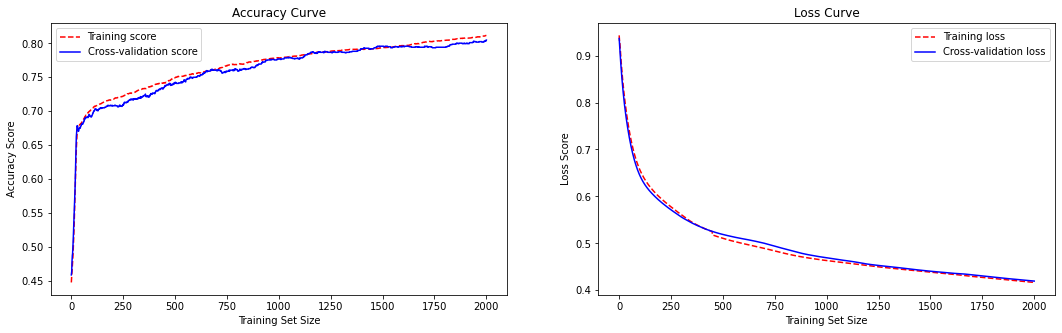

In [34]:
plot_acc_loss(acc_data_train_1, acc_data_val_1, loss_data_train_1, loss_data_val_1)

No handles with labels found to put in legend.


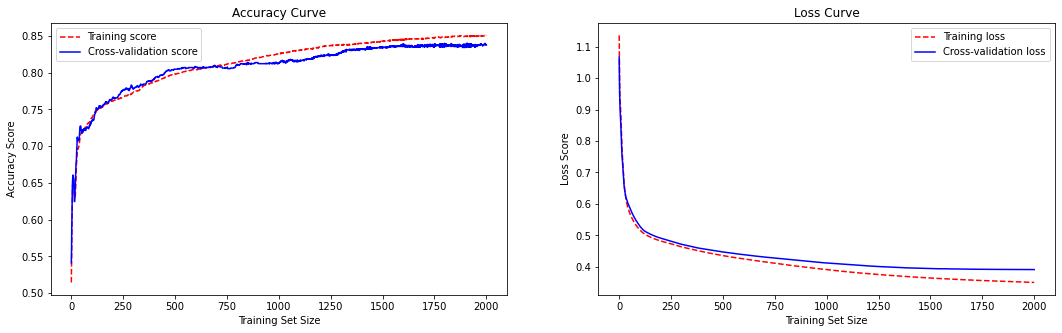

In [44]:
plot_acc_loss(acc_data_train_2, acc_data_val_2, loss_data_train_2, loss_data_val_2)

No handles with labels found to put in legend.


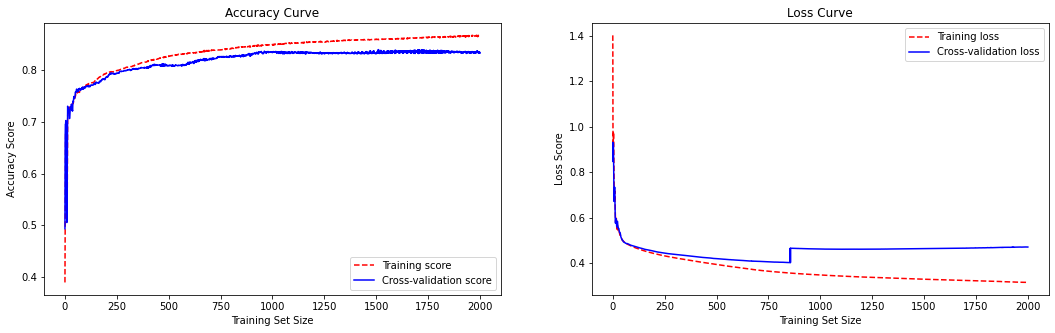

In [45]:
plot_acc_loss(acc_data_train_3, acc_data_val_3, loss_data_train_3, loss_data_val_3)

In [40]:
def evalute_test(model, X_test, y_test):
    model.eval()
    y_pred_test = model(X_test)
    cond = y_pred_test >= 0.5
    y_pred_test = torch.where(cond, 1, 0)
    train_acc = torch.sum(y_pred_test == y_test) / len(y_test)
    print(f"Model Acc. on Test Data {train_acc}")

In [43]:
evalute_test(model_1, X_test, y_test.reshape(-1, 1))
evalute_test(model_2, X_test, y_test.reshape(-1, 1))
evalute_test(model_3, X_test, y_test.reshape(-1, 1))

Model Acc. on Test Data 0.8117770552635193
Model Acc. on Test Data 0.8391166925430298
Model Acc. on Test Data 0.8378899693489075


### Scaling Data